# Detector de Spam

### Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import tensorflow as tf
from tensorflow import keras
from keras.metrics import BinaryAccuracy
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

### Análise Exploratória de Dados

In [2]:
emails = pd.read_csv('spam_or_not_spam.csv')

In [3]:
emails.head()

,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0


In [4]:
emails.shape

(3000, 2)

In [5]:
emails_dedupl = emails.drop_duplicates()

In [6]:
emails_filtered = emails_dedupl.dropna()

In [7]:
emails_filtered.shape

(2872, 2)

### Tratamento de Texto

In [8]:
df = emails_filtered.copy()

In [9]:
stemmer = PorterStemmer()

In [10]:
nltk.download("stopwords")
stopwords = stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Felipe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
df['unstemmed'] = df['email'].str.split()

In [12]:
df['unstemmed'] = df['unstemmed'].apply(lambda x: [re.sub(r"[^A-Za-z]", " ", y).lower() for y in x])

In [13]:
df['stemmed'] = df['unstemmed'].apply(lambda x: [stemmer.stem(y) for y in x if not y in stopwords])

In [14]:
df['stemmed_stopwords'] = df['stemmed'].apply(lambda x: [item for item in x if item not in stopwords])

In [15]:
df['features'] = df['stemmed_stopwords'].apply(lambda x: ' '.join(x))

In [16]:
df_prod = df[['features', 'label']]

In [17]:
df_prod.head()

,features,label
0,date wed number aug number number number numbe...,0
1,martin post tasso papadopoulo greek sculptor b...,0
2,man threaten explos moscow thursday august num...,0
3,klez viru die alreadi prolif viru ever klez co...,0
4,ad cream spaghetti carbonara effect pasta make...,0


In [18]:
df_prod.shape

(2872, 2)

### Codificações Baseadas em Palavras

In [19]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_prod)
train, validation = train_test_split(train, test_size=0.2)
print('Entradas por Dataset')
print('Dataset de Treino: ', len(train), 'linhas.')
print('Dataset de Validação: ', len(validation), 'linhas.')
print('Dataset de Teste: ', len(test), 'linhas.')

Entradas por Dataset
Dataset de Treino:  1723 linhas.
Dataset de Validação:  431 linhas.
Dataset de Teste:  718 linhas.


In [20]:
train.head()

,features,label
2972,hyperlink never pay retail manwoman mana woman...,1
2852,hyperlink click see bang busit wild tepyycemkc...,1
1342,steve thoma sthoma apexvoic com number number ...,0
920,sun number sep number bitbitch url wrote well ...,0
1905,url url date suppli new kpmg studi conclud ria...,0


In [21]:
train_ham = train[train['label'] == 0]
train_spam = train[train['label'] == 1]

In [22]:
print("Treino #ham: ", len(train_ham))
print("Treino #spam: ", len(train_spam))

Treino #ham:  1459
Treino #spam:  264


In [23]:
oversampling_factor = len(train_ham) // len(train_spam) # 5

In [24]:
train_spam = train_spam.sample(n=len(train_spam) * oversampling_factor,
                               replace=True)

In [25]:
train = pd.concat([train_ham, train_spam])

In [26]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

vocab_size = 10000
trunc_type = "post"
pad_type = "post"
oov_tok = "<OOV>"

In [27]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train.features)
word_index = tokenizer.word_index

In [28]:
word_index

{'<OOV>': 1,
 'number': 2,
 'url': 3,
 'mail': 4,
 'list': 5,
 'free': 6,
 'get': 7,
 'use': 8,
 'email': 9,
 'one': 10,
 'money': 11,
 'e': 12,
 'hyperlink': 13,
 'time': 14,
 'make': 15,
 'busi': 16,
 'receiv': 17,
 'new': 18,
 'peopl': 19,
 'year': 20,
 'name': 21,
 'order': 22,
 'work': 23,
 'pleas': 24,
 'inform': 25,
 'us': 26,
 'address': 27,
 'report': 28,
 'click': 29,
 'grant': 30,
 'want': 31,
 'would': 32,
 'messag': 33,
 'like': 34,
 'need': 35,
 'send': 36,
 'compani': 37,
 'state': 38,
 'remov': 39,
 'day': 40,
 'program': 41,
 'go': 42,
 'also': 43,
 'market': 44,
 'govern': 45,
 'home': 46,
 'offer': 47,
 'look': 48,
 'help': 49,
 'includ': 50,
 'user': 51,
 'way': 52,
 'servic': 53,
 'invest': 54,
 'know': 55,
 'see': 56,
 'may': 57,
 'take': 58,
 'right': 59,
 'world': 60,
 'start': 61,
 'first': 62,
 'million': 63,
 'follow': 64,
 'person': 65,
 'best': 66,
 'find': 67,
 'even': 68,
 'call': 69,
 'group': 70,
 'internet': 71,
 'chang': 72,
 'guid': 73,
 'de': 74,
 '

In [29]:
training_sequences = tokenizer.texts_to_sequences(np.array(train.features))

In [30]:
training_sequences[0:1]

[[1651,
  2448,
  1,
  1,
  181,
  2,
  2,
  490,
  2,
  2,
  43,
  7,
  277,
  89,
  8,
  216,
  4250,
  557,
  1652,
  3244,
  27,
  814,
  1258,
  2514,
  412,
  4855,
  132,
  2054,
  1043,
  10,
  484,
  379,
  2252,
  133,
  90,
  2722,
  5251,
  142,
  1469,
  1,
  709,
  2323,
  9,
  1316,
  160,
  952,
  1184,
  2923,
  3,
  1,
  1,
  2,
  1,
  1,
  3400,
  1,
  1,
  2449,
  2515,
  3572,
  3871,
  3,
  9,
  294,
  2095,
  60,
  962,
  546,
  205,
  14,
  178,
  974,
  1330,
  237,
  3,
  153,
  177,
  4,
  5,
  153,
  177,
  3,
  3]]

In [31]:
training_padded = pad_sequences(training_sequences, truncating=trunc_type, padding=pad_type)

In [32]:
max_length = len(training_padded[0])

In [33]:
max_length

7616

In [34]:
validation_sequences = tokenizer.texts_to_sequences(np.array(validation.features))
validation_padded = pad_sequences(validation_sequences, padding=pad_type, truncating=trunc_type, maxlen=max_length)

In [35]:
x_train = np.copy(training_padded)
x_val = np.copy(validation_padded)
y_train = train['label'].values
y_val = validation['label'].values

In [36]:
print('Tamanho dos Arrays')
print('Treino: ', len(x_train), 'linhas.')
print('Resposta: ', len(y_train), 'linhas.')

Tamanho dos Arrays
Treino:  2779 linhas.
Resposta:  2779 linhas.


### Rede Neural

In [37]:
embedding_dim = 16

model = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [38]:
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=[BinaryAccuracy()])

history = model.fit(x_train,
                    y_train,
                    verbose=1,
                    epochs=30,
                    validation_data=(x_val, y_val))

Epoch 1/30
87/87 [==============================] - 2s 16ms/step - loss: 0.6924 - binary_accuracy: 0.5207 - val_loss: 0.6681 - val_binary_accuracy: 0.8631
Epoch 2/30
87/87 [==============================] - 1s 15ms/step - loss: 0.6917 - binary_accuracy: 0.5250 - val_loss: 0.6621 - val_binary_accuracy: 0.8631
Epoch 3/30
87/87 [==============================] - 1s 14ms/step - loss: 0.6912 - binary_accuracy: 0.5250 - val_loss: 0.6546 - val_binary_accuracy: 0.8631
Epoch 4/30
87/87 [==============================] - 1s 14ms/step - loss: 0.6902 - binary_accuracy: 0.5250 - val_loss: 0.6491 - val_binary_accuracy: 0.8631
Epoch 5/30
87/87 [==============================] - 1s 14ms/step - loss: 0.6882 - binary_accuracy: 0.5398 - val_loss: 0.6464 - val_binary_accuracy: 0.8677
Epoch 6/30
87/87 [==============================] - 1s 15ms/step - loss: 0.6838 - binary_accuracy: 0.5534 - val_loss: 0.6282 - val_binary_accuracy: 0.8677
Epoch 7/30
87/87 [==============================] - 1s 14ms/step - los

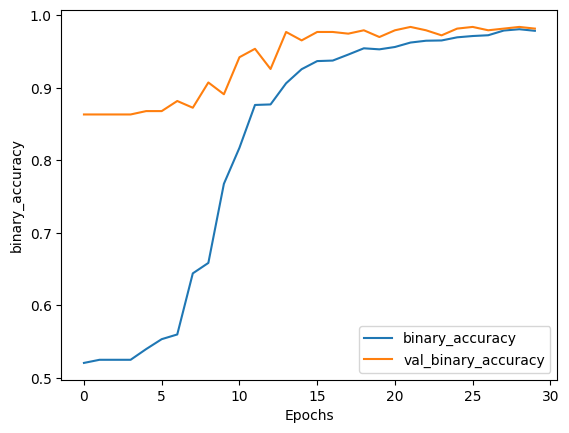

In [39]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_' + string])
    plt.show()

plot_graphs(history, "binary_accuracy")

### Teste

In [40]:
test_sequences = tokenizer.texts_to_sequences(np.array(test.features))
test_padded = pad_sequences(test_sequences,
                            padding=pad_type,
                            truncating=trunc_type,
                            maxlen=max_length)

In [41]:
x_test = np.copy(test_padded)
y_test = test['label'].values

In [42]:
threshold = 0.5
y_pred = (model.predict(x_test) > threshold).astype("int32")

23/23 [==============================] - 0s 4ms/step


In [43]:
print('Acurácia: ', accuracy_score(y_test, y_pred))

Acurácia:  0.9874651810584958


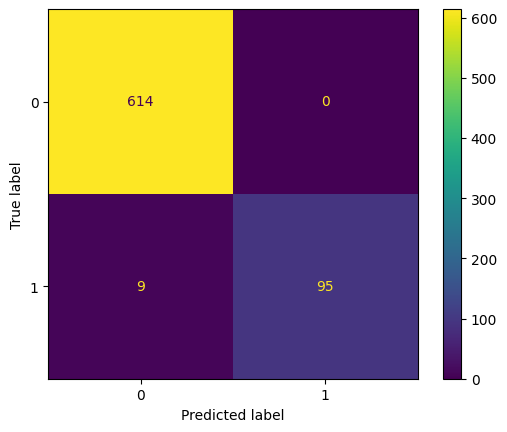

In [44]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)